In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

In [2]:
seed = 2
np.random.seed(seed)

# Monk1 #

Loading data for Monk1

In [3]:
colnames = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
monk1_tr = pd.read_csv("./dataset/monk1/monks-1.train", sep = " ", skipinitialspace=True, names = colnames)
monk1_tr = monk1_tr.drop('id', axis = 1)

monk1_ts = pd.read_csv("./dataset/monk1/monks-1.test", sep = " ", skipinitialspace=True, names = colnames)
monk1_ts = monk1_ts.drop('id', axis = 1)

Division of the sets into target set and input set

In [4]:
x_monk1_tr = monk1_tr.iloc[:, 1:7].values
y_monk1_tr = monk1_tr.iloc[:, 0].values
x_monk1_ts = monk1_ts.iloc[:, 1:7].values
y_monk1_ts = monk1_ts.iloc[:, 0].values

Perform a one-hot-encoding for each tests' attributes

In [5]:
one_hot_encoder_tr = OneHotEncoder(sparse=False)
one_hot_encoder_tr.fit(x_monk1_tr)
x_monk1_tr = one_hot_encoder_tr.transform(x_monk1_tr)

one_hot_encoder_ts = OneHotEncoder(sparse=False)
one_hot_encoder_ts.fit(x_monk1_ts)
x_monk1_ts = one_hot_encoder_ts.transform(x_monk1_ts)

x_monk1_tr, y_monk1_tr = shuffle(x_monk1_tr, y_monk1_tr)
x_monk1_ts, y_monk1_ts = shuffle(x_monk1_ts, y_monk1_ts)

So now the number of columns of our matrices passed from 6 to 17.

Let us now divide the design set into the training set and the validation test

In [6]:
subset_size = int(0.3 * len(x_monk1_tr))

index = np.random.choice(len(x_monk1_tr), subset_size, replace=False)
index = np.sort(index)

x_monk1_vl = x_monk1_tr[index]
y_monk1_vl = y_monk1_tr[index]

x_monk1_tr = np.delete(x_monk1_tr, index, 0)
y_monk1_tr = np.delete(y_monk1_tr, index, 0)

## Creating the model ##

Now we will use KerasTuner to find the best hyperparameters for the model selection phase.

In [182]:
def build_model(hp) :
    model = Sequential()
    model.add(
        Dense(
            units=hp.Int("units", min_value=2, max_value=11, step=3),
            activation="relu",
        )
    )
    model.add(Dense(1, activation="sigmoid"))
    learning_rate = hp.Choice("learning_rate", values=[0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0])
    momentum = hp.Choice("momentum", values=[0.0, 0.3, 0.5, 0.7, 0.8, 0.9])
    opt = optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(
        optimizer=opt, loss='mse', metrics=['accuracy']
    )
    return model

In [183]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=100,
    executions_per_trial=2,
    overwrite=True,
    directory="results/monk1",
    project_name="nn_RandomSearch/par_hp",
)

Brief summary of the search space

In [184]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 11, 'step': 3, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0], 'ordered': True}
momentum (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.3, 0.5, 0.7, 0.8, 0.9], 'ordered': True}


In [17]:
tuner.search(
    x_monk1_tr, y_monk1_tr, 
    epochs=200, 
    validation_data=(x_monk1_vl, y_monk1_vl)
)

Trial 88 Complete [00h 00m 17s]
val_accuracy: 0.7702702581882477

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 24m 23s
INFO:tensorflow:Oracle triggered exit


The results have been saved, now let's take a look to the results

In [115]:
best_hp = tuner.get_best_hyperparameters(3)

for i in range(len(best_hp)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "learning_rate", "momentum"]:
        print(h_param, best_hp[i].get(h_param))
    print("")

best hyperparameters n. 0
units 5
learning_rate 0.7
momentum 0.3

best hyperparameters n. 1
units 8
learning_rate 0.3
momentum 0.9

best hyperparameters n. 2
units 8
learning_rate 0.5
momentum 0.8



In [20]:
f_model = build_model(best_hp[0])
f_model.build(input_shape=(None, 17))

f_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 5)                 90        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________


In [21]:
tuner.results_summary()

Results summary
Results in results/monk1_parResults
Showing 10 best trials
Trial summary
Hyperparameters:
units: 5
learning_rate: 0.7
momentum: 0.3
Score: 1.0
Trial summary
Hyperparameters:
units: 8
learning_rate: 0.3
momentum: 0.9
Score: 0.9864864945411682
Trial summary
Hyperparameters:
units: 8
learning_rate: 0.5
momentum: 0.8
Score: 0.972972959280014
Trial summary
Hyperparameters:
units: 5
learning_rate: 0.3
momentum: 0.7
Score: 0.972972959280014
Trial summary
Hyperparameters:
units: 8
learning_rate: 0.7
momentum: 0.0
Score: 0.9594594538211823
Trial summary
Hyperparameters:
units: 8
learning_rate: 0.3
momentum: 0.7
Score: 0.9594594538211823
Trial summary
Hyperparameters:
units: 5
learning_rate: 1.0
momentum: 0.0
Score: 0.9594594538211823
Trial summary
Hyperparameters:
units: 2
learning_rate: 0.7
momentum: 0.8
Score: 0.9594594538211823
Trial summary
Hyperparameters:
units: 11
learning_rate: 1.0
momentum: 0.7
Score: 0.9459459483623505
Trial summary
Hyperparameters:
units: 8
learning_r

In [116]:
n_hp = len(best_hp)
n_trials = 5

models = [None]*n_hp
for i in range(n_hp):
    models[i] = [None]*n_trials

for i in range(n_hp):
    for j in range(n_trials):
        models[i][j] = build_model(best_hp[0])

x_monk1_ds = np.concatenate((x_monk1_tr, x_monk1_vl))
y_monk1_ds = np.concatenate((y_monk1_tr, y_monk1_vl))

n_epochs = 200
hist = [None]*n_hp
for i in range(n_hp):
    hist[i] = [None]*n_trials

for i in range(n_hp):
    for j in range(n_trials):
        hist[i][j] = models[i][j].fit(x=x_monk1_ds, y=y_monk1_ds, epochs=n_epochs)

Epoch 1/200
4/4 [==============================] - 0s 1ms/step - loss: 0.2679 - accuracy: 0.4597
Epoch 2/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2517 - accuracy: 0.5323
Epoch 3/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2468 - accuracy: 0.5484
Epoch 4/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2418 - accuracy: 0.5887
Epoch 5/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2374 - accuracy: 0.6129
Epoch 6/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2349 - accuracy: 0.6290
Epoch 7/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2309 - accuracy: 0.6694
Epoch 8/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2255 - accuracy: 0.6532
Epoch 9/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2146 - accuracy: 0.7016
Epoch 10/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2051 - accuracy: 0.7339
Epoch 11/200
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.0582 - accuracy: 0.9355
Epoch 85/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0581 - accuracy: 0.9355
Epoch 86/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0581 - accuracy: 0.9355
Epoch 87/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0581 - accuracy: 0.9355
Epoch 88/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0580 - accuracy: 0.9355
Epoch 89/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0580 - accuracy: 0.9355
Epoch 90/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0581 - accuracy: 0.9355
Epoch 91/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0580 - accuracy: 0.9355
Epoch 92/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0579 - accuracy: 0.9355
Epoch 93/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0579 - accuracy: 0.9355
Epoch 94/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0573 - accuracy: 0.9355
Epoch 168/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0572 - accuracy: 0.9355
Epoch 169/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0572 - accuracy: 0.9355
Epoch 170/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0572 - accuracy: 0.9355
Epoch 171/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0573 - accuracy: 0.9355
Epoch 172/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0573 - accuracy: 0.9355
Epoch 173/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0572 - accuracy: 0.9355
Epoch 174/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0572 - accuracy: 0.9355
Epoch 175/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0572 - accuracy: 0.9355
Epoch 176/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0572 - accuracy: 0.9355
Epoch 177/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.0731 - accuracy: 0.9355
Epoch 51/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0727 - accuracy: 0.9355
Epoch 52/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0721 - accuracy: 0.9355
Epoch 53/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0714 - accuracy: 0.9355
Epoch 54/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0709 - accuracy: 0.9355
Epoch 55/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0705 - accuracy: 0.9355
Epoch 56/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0701 - accuracy: 0.9355
Epoch 57/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0698 - accuracy: 0.9355
Epoch 58/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0694 - accuracy: 0.9355
Epoch 59/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0691 - accuracy: 0.9355
Epoch 60/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 134/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 135/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 136/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 137/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 138/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 139/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 140/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 141/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 142/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 143/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.0987 - accuracy: 0.8710
Epoch 17/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0943 - accuracy: 0.9032
Epoch 18/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0902 - accuracy: 0.9032
Epoch 19/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0860 - accuracy: 0.8871
Epoch 20/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0818 - accuracy: 0.9194
Epoch 21/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0795 - accuracy: 0.9113
Epoch 22/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0743 - accuracy: 0.9194
Epoch 23/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0714 - accuracy: 0.9113
Epoch 24/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0732 - accuracy: 0.9113
Epoch 25/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0696 - accuracy: 0.9194
Epoch 26/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 100/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 101/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 102/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 103/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 104/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 105/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 106/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 107/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 108/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 109/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 182/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 183/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 184/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 185/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 186/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 187/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 188/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 189/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 190/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 191/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.0139 - accuracy: 1.0000
Epoch 65/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 1.0000
Epoch 66/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 1.0000
Epoch 67/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0121 - accuracy: 1.0000
Epoch 68/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0116 - accuracy: 1.0000
Epoch 69/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 1.0000
Epoch 70/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0110 - accuracy: 1.0000
Epoch 71/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 1.0000
Epoch 72/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0102 - accuracy: 1.0000
Epoch 73/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0098 - accuracy: 1.0000
Epoch 74/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 148/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 149/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 150/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 151/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 152/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 153/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 154/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 155/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 156/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 157/200
4/4 [=====

4/4 [==============================] - 0s 1ms/step - loss: 0.0953 - accuracy: 0.8871
Epoch 31/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0917 - accuracy: 0.8871
Epoch 32/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0896 - accuracy: 0.8871
Epoch 33/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0881 - accuracy: 0.9194
Epoch 34/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0830 - accuracy: 0.9274
Epoch 35/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0799 - accuracy: 0.9355
Epoch 36/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0772 - accuracy: 0.9274
Epoch 37/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0771 - accuracy: 0.9355
Epoch 38/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0719 - accuracy: 0.9274
Epoch 39/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0683 - accuracy: 0.9355
Epoch 40/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 114/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 115/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 116/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 117/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 118/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 119/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 120/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 121/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 122/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 123/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 196/200
4/4 [==============================] - 0s 2ms/step - loss: 9.9661e-04 - accuracy: 1.0000
Epoch 197/200
4/4 [==============================] - 0s 2ms/step - loss: 9.8895e-04 - accuracy: 1.0000
Epoch 198/200
4/4 [==============================] - 0s 2ms/step - loss: 9.8241e-04 - accuracy: 1.0000
Epoch 199/200
4/4 [==============================] - 0s 2ms/step - loss: 9.7617e-04 - accuracy: 1.0000
Epoch 200/200
4/4 [==============================] - 0s 2ms/step - loss: 9.6929e-04 - accuracy: 1.0000
Epoch 1/200
4/4 [==============================] - 0s 1ms/step - loss: 0.3174 - accuracy: 0.3629
Epoch 2/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2668 - accuracy: 0.5000
Epoch 3/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2405 - accuracy: 0.5887
Epoch 4/200
4/4 [==============================] - 0s 1ms/step - loss: 0.2176 - accuracy: 0.7016
Epoch 5/200


4/4 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 1.0000
Epoch 79/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 1.0000
Epoch 80/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0137 - accuracy: 1.0000
Epoch 81/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0131 - accuracy: 1.0000
Epoch 82/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 1.0000
Epoch 83/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0122 - accuracy: 1.0000
Epoch 84/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0114 - accuracy: 1.0000
Epoch 85/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 1.0000
Epoch 86/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 1.0000
Epoch 87/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 1.0000
Epoch 88/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 162/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 163/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 164/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 165/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 166/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 167/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 168/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 169/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 170/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 171/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.0777 - accuracy: 0.9435
Epoch 45/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0793 - accuracy: 0.9194
Epoch 46/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0704 - accuracy: 0.9516
Epoch 47/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0693 - accuracy: 0.9435
Epoch 48/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0644 - accuracy: 0.9516
Epoch 49/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0634 - accuracy: 0.9435
Epoch 50/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0578 - accuracy: 0.9677
Epoch 51/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0537 - accuracy: 0.9758
Epoch 52/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0560 - accuracy: 0.9597
Epoch 53/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0504 - accuracy: 0.9677
Epoch 54/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 128/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 129/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 130/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 131/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 132/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 133/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 134/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 135/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 136/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 137/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.1726 - accuracy: 0.7500
Epoch 10/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1606 - accuracy: 0.7500
Epoch 11/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1538 - accuracy: 0.7903
Epoch 12/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1418 - accuracy: 0.8145
Epoch 13/200
4/4 [==============================] - 0s 1ms/step - loss: 0.1354 - accuracy: 0.8468
Epoch 14/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1284 - accuracy: 0.8387
Epoch 15/200
4/4 [==============================] - 0s 1ms/step - loss: 0.1232 - accuracy: 0.8710
Epoch 16/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1208 - accuracy: 0.8306
Epoch 17/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1191 - accuracy: 0.8790
Epoch 18/200
4/4 [==============================] - 0s 1ms/step - loss: 0.1167 - accuracy: 0.8387
Epoch 19/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 93/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 94/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 95/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 96/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 97/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 98/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 99/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 100/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 101/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 102/200
4/4 [============

4/4 [==============================] - 0s 2ms/step - loss: 9.9966e-04 - accuracy: 1.0000
Epoch 175/200
4/4 [==============================] - 0s 2ms/step - loss: 9.9286e-04 - accuracy: 1.0000
Epoch 176/200
4/4 [==============================] - 0s 2ms/step - loss: 9.8580e-04 - accuracy: 1.0000
Epoch 177/200
4/4 [==============================] - 0s 2ms/step - loss: 9.7152e-04 - accuracy: 1.0000
Epoch 178/200
4/4 [==============================] - 0s 2ms/step - loss: 9.6570e-04 - accuracy: 1.0000
Epoch 179/200
4/4 [==============================] - 0s 2ms/step - loss: 9.6155e-04 - accuracy: 1.0000
Epoch 180/200
4/4 [==============================] - 0s 2ms/step - loss: 9.4293e-04 - accuracy: 1.0000
Epoch 181/200
4/4 [==============================] - 0s 2ms/step - loss: 9.3686e-04 - accuracy: 1.0000
Epoch 182/200
4/4 [==============================] - 0s 2ms/step - loss: 9.2835e-04 - accuracy: 1.0000
Epoch 183/200
4/4 [==============================] - 0s 2ms/step - loss: 9.2427e-04 - a

4/4 [==============================] - 0s 2ms/step - loss: 0.0369 - accuracy: 0.9677
Epoch 57/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0335 - accuracy: 0.9839
Epoch 58/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 0.9677
Epoch 59/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0597 - accuracy: 0.9113
Epoch 60/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0310 - accuracy: 0.9839
Epoch 61/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0436 - accuracy: 0.9435
Epoch 62/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0322 - accuracy: 0.9919
Epoch 63/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0355 - accuracy: 0.9677
Epoch 64/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0265 - accuracy: 0.9919
Epoch 65/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0260 - accuracy: 0.9839
Epoch 66/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 140/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 141/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 142/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 143/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 144/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 145/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 146/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 147/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 148/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 149/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.1012 - accuracy: 0.8790
Epoch 23/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0993 - accuracy: 0.8710
Epoch 24/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0976 - accuracy: 0.8790
Epoch 25/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0958 - accuracy: 0.8629
Epoch 26/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0876 - accuracy: 0.9032
Epoch 27/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0828 - accuracy: 0.9113
Epoch 28/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0904 - accuracy: 0.8790
Epoch 29/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0893 - accuracy: 0.8548
Epoch 30/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0735 - accuracy: 0.9274
Epoch 31/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0663 - accuracy: 0.9435
Epoch 32/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 106/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 107/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 108/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 109/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 110/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 111/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 112/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 113/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 114/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 115/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 7.1337e-04 - accuracy: 1.0000
Epoch 187/200
4/4 [==============================] - 0s 2ms/step - loss: 7.1034e-04 - accuracy: 1.0000
Epoch 188/200
4/4 [==============================] - 0s 2ms/step - loss: 7.0178e-04 - accuracy: 1.0000
Epoch 189/200
4/4 [==============================] - 0s 2ms/step - loss: 6.9317e-04 - accuracy: 1.0000
Epoch 190/200
4/4 [==============================] - 0s 2ms/step - loss: 6.8755e-04 - accuracy: 1.0000
Epoch 191/200
4/4 [==============================] - 0s 2ms/step - loss: 6.8257e-04 - accuracy: 1.0000
Epoch 192/200
4/4 [==============================] - 0s 2ms/step - loss: 6.7801e-04 - accuracy: 1.0000
Epoch 193/200
4/4 [==============================] - 0s 2ms/step - loss: 6.7134e-04 - accuracy: 1.0000
Epoch 194/200
4/4 [==============================] - 0s 2ms/step - loss: 6.6634e-04 - accuracy: 1.0000
Epoch 195/200
4/4 [==============================] - 0s 2ms/step - loss: 6.6133e-04 - a

4/4 [==============================] - 0s 2ms/step - loss: 0.0106 - accuracy: 1.0000
Epoch 70/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0099 - accuracy: 1.0000
Epoch 71/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0094 - accuracy: 1.0000
Epoch 72/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0092 - accuracy: 1.0000
Epoch 73/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0089 - accuracy: 1.0000
Epoch 74/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 1.0000
Epoch 75/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 1.0000
Epoch 76/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0081 - accuracy: 1.0000
Epoch 77/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 1.0000
Epoch 78/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0077 - accuracy: 1.0000
Epoch 79/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 153/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 154/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 155/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 156/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 157/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 158/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 159/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 160/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 161/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 162/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.0836 - accuracy: 0.9274
Epoch 36/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0807 - accuracy: 0.9194
Epoch 37/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0806 - accuracy: 0.9113
Epoch 38/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0782 - accuracy: 0.9274
Epoch 39/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0728 - accuracy: 0.9435
Epoch 40/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0655 - accuracy: 0.9194
Epoch 41/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0628 - accuracy: 0.9435
Epoch 42/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0597 - accuracy: 0.9355
Epoch 43/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0583 - accuracy: 0.9597
Epoch 44/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0526 - accuracy: 0.9597
Epoch 45/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 119/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 120/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 121/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 122/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 123/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 124/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 125/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 126/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 127/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 128/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 8.0847e-04 - accuracy: 1.0000
Epoch 1/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2540 - accuracy: 0.5161
Epoch 2/200
4/4 [==============================] - 0s 1ms/step - loss: 0.2469 - accuracy: 0.5645
Epoch 3/200
4/4 [==============================] - 0s 1ms/step - loss: 0.2407 - accuracy: 0.5887
Epoch 4/200
4/4 [==============================] - 0s 1ms/step - loss: 0.2348 - accuracy: 0.6210
Epoch 5/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2256 - accuracy: 0.6371
Epoch 6/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2164 - accuracy: 0.6935
Epoch 7/200
4/4 [==============================] - 0s 2ms/step - loss: 0.2038 - accuracy: 0.7097
Epoch 8/200
4/4 [==============================] - 0s 1ms/step - loss: 0.1914 - accuracy: 0.7661
Epoch 9/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1790 - accuracy: 0.7742
Epoch 10/200
4/4 [====================

4/4 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 1.0000
Epoch 84/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0082 - accuracy: 1.0000
Epoch 85/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 1.0000
Epoch 86/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0077 - accuracy: 1.0000
Epoch 87/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0074 - accuracy: 1.0000
Epoch 88/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0072 - accuracy: 1.0000
Epoch 89/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0070 - accuracy: 1.0000
Epoch 90/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0068 - accuracy: 1.0000
Epoch 91/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0066 - accuracy: 1.0000
Epoch 92/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 93/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 167/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 168/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 169/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 170/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 171/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 172/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 173/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 174/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 175/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 176/200
4/4 [=====

4/4 [==============================] - 0s 1ms/step - loss: 0.0078 - accuracy: 1.0000
Epoch 50/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0074 - accuracy: 1.0000
Epoch 51/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 52/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0067 - accuracy: 1.0000
Epoch 53/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0063 - accuracy: 1.0000
Epoch 54/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0060 - accuracy: 1.0000
Epoch 55/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 56/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0056 - accuracy: 1.0000
Epoch 57/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 58/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 59/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 133/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 134/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 135/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 136/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 137/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 138/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 139/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 140/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 141/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 142/200
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 0.1495 - accuracy: 0.8387
Epoch 13/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1452 - accuracy: 0.8306
Epoch 14/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1421 - accuracy: 0.8548
Epoch 15/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1373 - accuracy: 0.8387
Epoch 16/200
4/4 [==============================] - 0s 1ms/step - loss: 0.1342 - accuracy: 0.8548
Epoch 17/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1301 - accuracy: 0.8306
Epoch 18/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1303 - accuracy: 0.8629
Epoch 19/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1267 - accuracy: 0.8468
Epoch 20/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1231 - accuracy: 0.8548
Epoch 21/200
4/4 [==============================] - 0s 2ms/step - loss: 0.1221 - accuracy: 0.8629
Epoch 22/200
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 96/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0067 - accuracy: 1.0000
Epoch 97/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 98/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 1.0000
Epoch 99/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0061 - accuracy: 1.0000
Epoch 100/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 101/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 1.0000
Epoch 102/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 103/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 104/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 105/200
4/4 [=========

4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 178/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 179/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 180/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 181/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 182/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 183/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 184/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 185/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 186/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 187/200
4/4 [=====

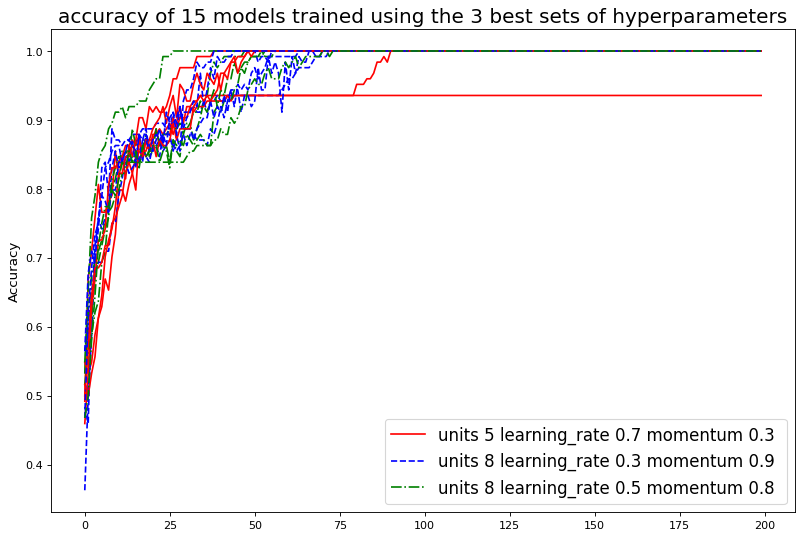

In [177]:
labels = [None]*n_hp
for i in range(n_hp):
    labels[i] = ""
    for h_param in ["units", "learning_rate", "momentum"]:
        labels[i] += h_param + " " + str(best_hp[i].get(h_param)) + " "

colours = ["red", "blue", "green", "purple", "olive", "grey"]
linestyles = ["solid", "dashed", "dashdot", "dotted", (0, (1,1)), (5, (5, 10))]

plt.figure(figsize=(12, 8), dpi=80)
for i in range(n_trials):
    for j in range(n_hp):
        plt.plot(hist[j][i].history['accuracy'], color=colours[j], linestyle=linestyles[j])

plt.title(
    "accuracy of " + str(n_hp*n_trials) + " models trained using the " + str(n_hp) +
    " best sets of hyperparameters", size=18
)
plt.ylabel("Accuracy", size=12)
plt.legend(labels, prop={'size': 15})
plt.savefig("./plots/monk1/nn_RandomSearch/ms_accuracy.png")
plt.show()

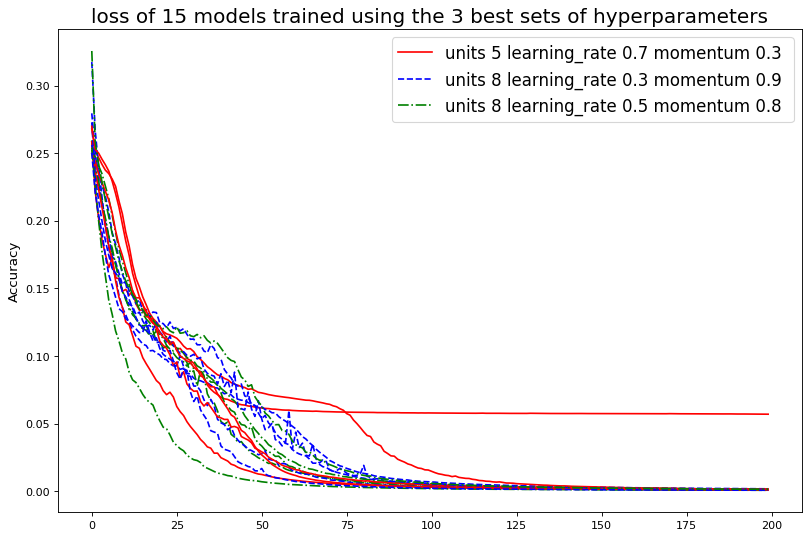

In [179]:
plt.figure(figsize=(12, 8), dpi=80)
for i in range(n_trials):
    for j in range(n_hp):
        plt.plot(hist[j][i].history['loss'], color=colours[j], linestyle=linestyles[j])

plt.title(
    "loss of " + str(n_hp*n_trials) + " models trained using the " + str(n_hp) +
    " best sets of hyperparameters", size=18
)
plt.ylabel("Accuracy", size=12)
plt.legend(labels, prop={'size': 15})
plt.savefig("./plots/monk1/nn_RandomSearch/ms_loss.png")
plt.show()

In [161]:
print("Final accuracy reached for each of the " + str(n_hp*n_trials) + " models\n")

for i in range(n_hp):
    print("set of hyperparameters n." + str(i) + ": " + labels[i])
    for j in range(n_trials):
        print(hist[i][j].history['accuracy'][n_epochs - 1], end=" - ")
    print("\n")

Final accuracy reached for each of the 15 models

set of hyperparameters n.0: units 5 learning_rate 0.7 momentum 0.3 
0.9354838728904724 - 1.0 - 1.0 - 1.0 - 1.0 - 

set of hyperparameters n.1: units 8 learning_rate 0.3 momentum 0.9 
1.0 - 1.0 - 1.0 - 1.0 - 1.0 - 

set of hyperparameters n.2: units 8 learning_rate 0.5 momentum 0.8 
1.0 - 1.0 - 1.0 - 1.0 - 1.0 - 



In [166]:
acc = None
best_acc = -1.0
best_model = None

for i in range(n_hp):
    for j in range(n_trials):
        acc = hist[i][j].history['accuracy'][n_epochs - 1]
        if (acc > best_acc):
            best_acc = acc
            best_model = models[i][j]
            
best_model.save("results/monk1/nn_RandomSearch/final_model/")

INFO:tensorflow:Assets written to: results/monk1/nn_RandomSearch/final_model/assets


here it finishes the phase of model selection

## Model Assessment ##

In [167]:
score = best_model.evaluate(x_monk1_ts, y_monk1_ts)

14/14 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 1.0000


In [173]:
print(
    "Final error (MSE) on the test set: " + str(score[0]) + "\n" +
    "Final accuracy on the test set: " + str(score[1])
)

Final error (MSE) on the test set: 0.0023981791455298662
Final accuracy on the test set: 1.0
